In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy

import copy
import abc
import math
from random import random, choices
from tqdm.auto import tqdm as tqdm
from collections import defaultdict, Counter
import graphviz

sns.set()

In [118]:
"""
Classes and methods for working with nondeterministic finite automata.
Source: https://github.com/caleb531/automata
"""


def ddict2dict(d):
    for k, v in d.items():
        if isinstance(v, dict):
            d[k] = ddict2dict(v)
    return dict(d)

def retries_for_sample(kappa: int)->int:
    return math.ceil(
        (2 + math.log(4) + 8 * math.log(kappa)) /
        math.log(1. / (1. - math.exp(-9.)))
    )

class AutomatonException(Exception):
    """The base class for all automaton-related errors."""
    pass


class InvalidStateError(AutomatonException):
    """A state is not a valid state for this automaton."""
    pass


class InvalidSymbolError(AutomatonException):
    """A symbol is not a valid symbol for this automaton."""
    pass


class MissingStateError(AutomatonException):
    """A state is missing from the automaton definition."""
    pass


class RejectionException(AutomatonException):
    """The input was rejected by the automaton."""
    pass


class Automaton(metaclass=abc.ABCMeta):
    """An abstract base class for all automata, including Turing machines."""

    @abc.abstractmethod
    def __init__(self):
        """Initialize a complete automaton."""
        raise NotImplementedError

    @abc.abstractmethod
    def validate(self):
        """Return True if this automaton is internally consistent."""
        raise NotImplementedError

    @abc.abstractmethod
    def read_input_stepwise(self, input_str):
        """Return a generator that yields each step while reading input."""
        raise NotImplementedError

    def read_input(self, input_str, validate_final=True):
        """
        Check if the given string is accepted by this automaton.

        Return the automaton's final configuration. If validate_final is true,
        this will return the final configuration only if this string is valid,
        raising RejectionException otherwise.
        """
        validation_generator = self.read_input_stepwise(input_str, validate_final=validate_final)
        for config in validation_generator:
            pass
        return config
    
    
    def accepts_input(self, input_str):
        """Return True if this automaton accepts the given input."""
        try:
            self.read_input(input_str)
            return True
        except RejectionException:
            return False

    def _validate_initial_states(self):
        """Raise an error if any of the initial states is invalid."""
        invalid_states = self.initial_states - self.states
        if invalid_states:
            raise InvalidStateError(
                'inital states are not valid ({})'.format(
                    ', '.join(str(state) for state in invalid_states)))

    def _validate_initial_states_transitions(self):
        """Raise an error if any initial state has no transitions defined."""
        for initial_state in self.initial_states:
            if initial_state not in self.transitions:
                raise MissingStateError(
                    'initial state {} has no transitions defined'.format(
                        initial_state))

    def _validate_final_states(self):
        """Raise an error if any final states are invalid."""
        invalid_states = self.final_states - self.states
        if invalid_states:
            raise InvalidStateError(
                'final states are not valid ({})'.format(
                    ', '.join(str(state) for state in invalid_states)))

    def copy(self):
        """Create a deep copy of the automaton."""
        return self.__class__(**vars(self))

    def __eq__(self, other):
        """Check if two automata are equal."""
        return vars(self) == vars(other)


class FA(Automaton, metaclass=abc.ABCMeta):
    """An abstract base class for finite automata."""
    pass


class NFA(FA):
    """A nondeterministic finite automaton."""
    def __init__(self, *, states, input_symbols, transitions,
                 initial_states, final_states,
                 states_by_layer=None, reverse_transitions=None):
        """Initialize a complete NFA."""
        self.states = states.copy()
        self.input_symbols = input_symbols.copy()
        self.transitions = copy.deepcopy(transitions)
        self.initial_states = initial_states
        self.final_states = final_states.copy()
        self.validate()

        # --- Counting utilities ---
        self.states_by_layer = states_by_layer
        self.sketch = defaultdict(dict)
        self.n_for_sets = {}
        self.n_for_states = {}
        self.s_for_states = defaultdict(Counter)
        self.reverse_transitions = reverse_transitions
        self.sorted_symbols = sorted(self.input_symbols)
        

    def _validate_transition_invalid_symbols(self, start_state, paths):
        """Raise an error if transition symbols are invalid."""
        for input_symbol in paths.keys():
            if input_symbol not in self.input_symbols and input_symbol != '':
                raise InvalidSymbolError(
                    'state {} has invalid transition symbol {}'.format(
                        start_state, input_symbol))

    def _validate_transition_end_states(self, start_state, paths):
        """Raise an error if transition end states are invalid."""
        for end_states in paths.values():
            for end_state in end_states:
                if end_state not in self.states:
                    raise InvalidStateError(
                        'end state {} for transition on {} is '
                        'not valid'.format(end_state, start_state))

    def validate(self):
        """Return True if this NFA is internally consistent."""
        for start_state, paths in self.transitions.items():
            self._validate_transition_invalid_symbols(start_state, paths)
            self._validate_transition_end_states(start_state, paths)
        self._validate_initial_states()
        self._validate_initial_states_transitions()
        self._validate_final_states()
        return True

    def __get_epsilon_closure(self, start_state):
        """
        Return the epsilon closure for the given state.

        The epsilon closure of a state q is the set containing q, along with
        every state that can be reached from q by following only epsilon
        transitions.
        """
        stack = []
        encountered_states = set()
        stack.append(start_state)

        while stack:
            state = stack.pop()
            if state not in encountered_states:
                encountered_states.add(state)
                if '' in self.transitions[state]:
                    stack.extend(self.transitions[state][''])

        return encountered_states

    def _get_next_current_states(self, current_states, input_symbol):
        """Return the next set of current states given the current set."""
        next_current_states = set()
        for current_state in current_states:
            symbol_end_states = self.transitions[current_state].get(
                input_symbol)
            if symbol_end_states:
                for end_state in symbol_end_states:
                        next_current_states.add(end_state)

        return next_current_states
    
        """
        for current_state in current_states:
            symbol_end_states = self.transitions[current_state].get(
                input_symbol)
            if symbol_end_states:
                for end_state in symbol_end_states:
                    next_current_states.update(
                        self._get_epsilon_closure(end_state))

        return next_current_states
        """

    def _check_for_input_rejection(self, current_states):
        """Raise an error if the given config indicates rejected input."""
        if not (current_states & self.final_states):
            raise RejectionException(
                'the NFA stopped on all non-final states ({})'.format(
                    ', '.join(str(state) for state in current_states)))

    def read_input_stepwise(self, input_str, validate_final=True):
        """
        Check if the given string is accepted by this NFA.

        Yield the current configuration of the NFA at each step.
        """
        # current_states = self._get_epsilon_closure(self.initial_state)
        current_states = self.initial_states

        yield current_states
        for input_symbol in input_str:
            current_states = self._get_next_current_states(
                current_states, input_symbol)
            yield current_states
        
        if validate_final:
            self._check_for_input_rejection(current_states)
            
    def reachable(self, input_str: str, state)->bool:
        """
        Returns true if the NFA reaches the state after reading input_str
        """
        return bool(self.read_input(input_str, validate_final=False) & set([state]))
    
    @staticmethod
    def remove_unreachable_states(initial_states: set, transitions: dict, n: int):
        """
        Filters states that are unreachable from an initial state
        by traversing one layer at a time.
        
        It returns a tuple of the form
        (
            all_reachable_states: set of states,
            reachable_states_by_layer: dict of layer -> set of states,
            reachable_transitions: dict of state p -> symbol a -> state q,
            rev_reachable_transitions: dict of state q -> symbol a -> state p,
        )
        
        Note that here states are tuples of strings (former states) and layer integers.
        """
        reachable_states_by_layer = {0: initial_states}
        all_reachable_states = initial_states.copy()
        for next_layer in range(1, n+1):
            this_layer_reachable = reachable_states_by_layer[next_layer-1]
            next_layer_reachable = set()
            for current_state in this_layer_reachable:
                for symbol, new_states in transitions[current_state].items():
                    for new_state in new_states:
                        next_layer_reachable.add(new_state)
            all_reachable_states.update(next_layer_reachable)
            reachable_states_by_layer[next_layer] = next_layer_reachable
        
        
        reachable_transitions = defaultdict(lambda: defaultdict(set))
        rev_reachable_transitions = defaultdict(lambda: defaultdict(set))
        
        for p, trans in transitions.items():
            if p not in all_reachable_states:
                print(f"Unreachable state {p} was removed")
                continue
            for a, qs in trans.items():
                for q in qs:
                    if q not in all_reachable_states:
                        print(f"Unreachable state {q} was removed")
                        continue
                    reachable_transitions[p][a].add(q)
                    rev_reachable_transitions[q][a].add(p)
                    
        
        return all_reachable_states, reachable_states_by_layer, reachable_transitions, rev_reachable_transitions
    
    
    def unroll(self, n: int):
        """
        Builds A_unroll with n levels
        to estimate |L(F^n)|
        """
        # for each state q ∈ Q, include copies q_0 , q_1 , ..., q n in A unroll
        new_states = {(q,i) for q in self.states for i in range(1, n+1)}
        # new_states_by_layer = {i: {(q,i) for q in self.states} for i in range(1, n+1)}
        new_states.update({(q,0) for q in self.initial_states})
        # new_states_by_layer = {0: {(q,0) for q in self.initial_states}}
        
        # for each transition (p, a, q) ∈ ∆ and i ∈ {0, 1, . . . , n − 1}, include
        # transition (p_i, a, q_i+1) in A unroll
        new_transitions = defaultdict(lambda: defaultdict(set))
        rev_transitions = defaultdict(lambda: defaultdict(set))
        for p, trans in self.transitions.items():
            for a, qs in trans.items():
                for q in qs:
                    for i in range(n):
                        # state -> symbol -> set of states
                        new_transitions[p,i][a].add((q,i+1))
                        rev_transitions[q,i+1][a].add((p,i))
        
        
        new_initial_states = {(q,0) for q in self.initial_states}
        new_final_states = {(q,n) for q in self.final_states}
        # cleanup of unreachable states
        new_states, new_states_by_layer, new_transitions, rev_transitions = NFA.remove_unreachable_states(
            initial_states=new_initial_states, transitions=new_transitions, n=n
        )
        new_transitions = ddict2dict(new_transitions)
        rev_transitions = ddict2dict(rev_transitions)
        print(new_transitions)
        nfa_unroll =  NFA(states=new_states,
                          input_symbols=self.input_symbols,
                          transitions=new_transitions,
                          initial_states=new_initial_states,
                          final_states=new_final_states,
                          states_by_layer=new_states_by_layer,
                          reverse_transitions=rev_transitions)
        
        return nfa_unroll
    
    def compute_n_for_single_state(self, state):
        """
        Compute N(pᵅ) = Σ N(R_b) for R_b being the set of 
        incoming states which connect to pᵅ after reading symbol b.
        
        In simple terms, it receives a states and estimates
        the number of different strings leading to it.
        """
        
        if state in self.n_for_states:
            return self.n_for_states[state]
        
        # will store all the states on layer i-1
        # which lead to q after reading b={0,1}
        # {'0': {...leading_states}, '1': {...leading_states}}
        r_b = {}
        # will store all the N(Pᵅ) calculated with `compute_n_for_states_set`
        n_r_b = {}
        for b in self.sorted_symbols:
            if b in self.reverse_transitions[state]:
                leading_states = self.reverse_transitions[state][b]
                r_b[b] = leading_states
                print(f"{state=}", f"{leading_states=}")
                n_r_b[b] = self.compute_n_for_states_set(frozenset(leading_states))
        print(n_r_b)
        n_q_alpha = sum(n_r_b.values())
        self.n_for_states[state] = n_q_alpha
        return n_q_alpha
    
    
    def compute_n_for_states_set(self, states: frozenset):
        """
        Compute N(Pᵅ) = Σ N(pᵅ)· |S(pᵅ)-Union(L(qᵅ) for q ≺ p)| / |S(pᵅ)|
        
        In simple terms, it receives a set of states and estimates
        the number of different strings leading to all of them.
        """
        if not states:
            return 0
        if states in self.n_for_sets:
            return self.n_for_sets[states]
        
        
        states_list = sorted(states) # linear order ≺
        total = self.n_for_states[states_list[0]]
        for i in range(1, len(states_list)):
            # states[i] = (q, i), where q is the original state name in A
            anchor_state = states_list[i] 
            state_name, level = anchor_state
            intersection_count = 0
            s_size = 0
            # Now estimate the intersection rate for anchor_state
            for previous_state in states_list[:i]:
                for string, count in self.s_for_states[previous_state].items():
                    s_size += count
                    if not self.reachable(input_str=string, state=previous_state):
                        intersection_count += count
            intersection_rate = intersection_count / s_size if s_size > 0 else 0
            print("inside n_states_set", anchor_state, self.n_for_states, intersection_rate)
            total += self.compute_n_for_single_state(anchor_state) * intersection_rate
        # cache the result
        self.n_for_sets[states] = total
        return total
        
    
    def sample(self, beta: int, states: frozenset, curr_string: str, phi: float):
        if beta == 0:
            print(phi)
            if random() <= phi:
                return curr_string
            # return "fail"
            return curr_string
        # will store all the states on layer i-1
        # which lead to r after reading b={0,1}
        # {'0': {...leading_states}, '1': {...leading_states}}
        p_beta_b = {}
        # will store all the N(Pᵅ) calculated with `compute_n_for_states_set`
        n_p_beta_b = {}
        
        for b in self.sorted_symbols:
            all_leading_states = set()
            for r in states:
                all_leading_states.update(self.reverse_transitions.get(r, {}).get(b, set()))
            fzset = frozenset(all_leading_states)
            #print(f"{fzset=}")
            p_beta_b[b] = fzset
            n_p_beta_b[b] = self.compute_n_for_states_set(fzset)
            
        sum_n_p_beta = sum(n_p_beta_b.values())
        if sum_n_p_beta == 0:
            #print("Sum = 0")
            return None
        chosen_symbol = choices(self.sorted_symbols, 
                                weights=[n_p_beta_b[b] / sum_n_p_beta for b in self.sorted_symbols],
                                k=1)[0]
        curr_string = chosen_symbol + curr_string # w_beta-1 = b · w_beta
        chosen_states = p_beta_b[chosen_symbol] # p_beta-1 
        new_probability = phi / (n_p_beta_b[chosen_symbol] / sum_n_p_beta) # phi / p_b
        return self.sample(beta=beta-1, states=chosen_states, curr_string=curr_string, phi=new_probability)
    
    
    def count_accepted(self, n:int, eps: float):
        """
        Returns a (1 ± ε)-approximation of |L_n(A_unroll)|
        """
        kappa = math.ceil(n * len(self.states) / eps)
        # c(κ)
        retries_sample = retries_for_sample(kappa) // 10000
        sample_size = 2 * kappa # 2 * kappa ** 7
        # For each state q ∈ I, set N(q_0) = |L(q_0)| = 1 
        # and S(q_0) = L(q_0) = {λ}
        for q in self.states_by_layer[0]:
            self.s_for_states[q] = {'': sample_size}
            self.n_for_states[q] = 1
            
        # For each i = 1, . . . , n and state q ∈ Q:
        #   (a) Compute N(q i ) given sketch[i − 1]
        #   (b) Sample polynomially many uniform elements from L(q_i) using
        #       N(q_i) and sketch[i − 1], and let S(q_i) be the multiset of
        #       uniform samples obtained
        for i in range(1, n+1):
            for q in self.states_by_layer[i]:
                n_q_alpha = self.compute_n_for_single_state(q)
                print(q, "n_q_alpha", n_q_alpha)
                if n_q_alpha == 0:
                    continue
                this_q_samples = Counter()
                for _ in tqdm(range(sample_size)):
                    for retry in range(retries_sample):
                        potential_sample = self.sample(beta=n, 
                                                       states=frozenset([q]),
                                                       curr_string='',
                                                       phi=math.exp(-5)/n_q_alpha)
                        if potential_sample == "fail":
                            print("fail")
                            return 0
                        elif potential_sample is None:
                            continue
                        this_q_samples.update([potential_sample])
                        break
                    
                # print(this_q_samples)
                self.s_for_states[q] = this_q_samples
        return self.compute_n_for_states_set(frozenset(self.final_states))
                        
                
    def bruteforce_save_all(self, n: int):
        if n == 0:
            return [''] if self.accepts_input('') else []
        accepted_strings = []
        for i in range(2**n):
            string_i = bin(i)[2:].zfill(n)
            if self.accepts_input(string_i):
                accepted_strings.append(string_i)
        return accepted_strings

    def bruteforce_count_only(self, n: int):
        if n == 0:
            return 1 if self.accepts_input('') else 0
        accepted_count = 0
        for i in tqdm(range(2**n)):
            string_i = bin(i)[2:].zfill(n)
            if self.accepts_input(string_i):
                accepted_count += 1
        return accepted_count
    
    
    def bruteforce_dfs(self, n: int):
        if n == 0:
            return 1 if self.accepts_input('') else 0
        accepted_count = 0
        visit_queue = [(s, 0) for s in self.initial_states] # FIFO queue
        while visit_queue:
            curr_state, curr_len = visit_queue.pop(-1)
            if curr_len == n:
                if curr_state in self.final_states:
                    accepted_count += 1
                continue
            for symbol, next_states in self.transitions.get(curr_state, {}).items():
                for next_state in next_states:
                    visit_queue.append((next_state, curr_len + 1))
        return accepted_count

    def plot(self):
        
        dot = graphviz.Digraph(name="NFA", 
                               graph_attr={"rankdir": "LR",
                                           "ranksep": "0.5",
                                           "nodesep": "0.6"})
        
        for s in self.states - self.final_states:
            dot.node(s, shape="circle")
            if s in self.initial_states:
                dot.node(f"{s}_init", label="", shape="none", height="0", width="0")
                dot.edge(f"{s}_init", s)
        
        for s in self.final_states:
            dot.node(s, shape="doublecircle")
                
        for curr_state, symbol_next_states in self.transitions.items():
            defer_labels = []
            for symbol, next_states in symbol_next_states.items():
                for next_state in next_states:
                    if next_state == curr_state:
                        defer_labels.append(symbol)
                        continue
                    dot.edge(curr_state, next_state, label=symbol)
            if defer_labels:
                dot.edge(curr_state, curr_state, label=",".join(defer_labels))

        return dot
        

In [122]:
nfa = NFA(
    states={'q0', 'q1', 'q2', 'q3', 'q4', 'q5', 'q6'},
    input_symbols={'0', '1'},
    transitions={
        'q0': {'0': {'q1'}, '1': {'q3'}},
        'q1': {'0': {'q2'}},
        'q2': {'0': {'q2'}, '1': {'q2'}},
        'q3': {'0': {'q4'}},
        'q4': {'0': {'q5'}},
        'q5': {'0': {'q6'}},
        'q6': {'0': {'q6'}, '1': {'q6'}},
    },
    initial_states={'q0'},
    final_states={'q2', 'q6'}
)

In [197]:
nfa = NFA(
    states={'q0', 'q1', 'q2'},
    input_symbols={'0', '1'},
    transitions={
        'q0': {'0': {'q1'}},
        # Use '' as the key name for empty string (lambda/epsilon) transitions
        'q1': {'0': {'q1'}, '1': {'q0', 'q2'}},
        'q2': {'1': {'q0'}}
    },
    initial_states={'q0'},
    final_states={'q1'}
)

In [13]:
%%timeit
nfa.bruteforce_count_only(20)

  0%|          | 0/1048576 [00:00<?, ?it/s]

  0%|          | 0/1048576 [00:00<?, ?it/s]

  0%|          | 0/1048576 [00:00<?, ?it/s]

  0%|          | 0/1048576 [00:00<?, ?it/s]

  0%|          | 0/1048576 [00:00<?, ?it/s]

  0%|          | 0/1048576 [00:00<?, ?it/s]

  0%|          | 0/1048576 [00:00<?, ?it/s]

  0%|          | 0/1048576 [00:00<?, ?it/s]

5.78 s ± 63.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [120]:
%%timeit
nfa.bruteforce_dfs(10)

158 µs ± 716 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [126]:
%%time
nfa.bruteforce_dfs(29)

CPU times: user 1min 19s, sys: 0 ns, total: 1min 19s
Wall time: 1min 19s


167772160

In [24]:
nfa.bruteforce_count_only(20), nfa.bruteforce_dfs(20)

  0%|          | 0/1048576 [00:00<?, ?it/s]

(327680, 327680)

In [37]:
nfa.reachable('00101', 'q2')

True

In [200]:
def count_nfa(nfa: NFA, n: int, eps: float):
    nfa_unroll = nfa.unroll(n)
    return nfa_unroll.count_accepted(n=n, eps=eps)

In [201]:
count_nfa(nfa, 5, 0.99)

Unreachable state ('q0', 1) was removed
Unreachable state ('q1', 0) was removed
Unreachable state ('q2', 0) was removed
Unreachable state ('q2', 1) was removed
{('q0', 0): {'0': {('q1', 1)}}, ('q0', 2): {'0': {('q1', 3)}}, ('q0', 3): {'0': {('q1', 4)}}, ('q0', 4): {'0': {('q1', 5)}}, ('q1', 1): {'0': {('q1', 2)}, '1': {('q2', 2), ('q0', 2)}}, ('q1', 2): {'0': {('q1', 3)}, '1': {('q2', 3), ('q0', 3)}}, ('q1', 3): {'0': {('q1', 4)}, '1': {('q0', 4), ('q2', 4)}}, ('q1', 4): {'0': {('q1', 5)}, '1': {('q0', 5), ('q2', 5)}}, ('q2', 2): {'1': {('q0', 3)}}, ('q2', 3): {'1': {('q0', 4)}}, ('q2', 4): {'1': {('q0', 5)}}}
state=('q1', 1) leading_states={('q0', 0)}
{'0': 1}
('q1', 1) n_q_alpha 1


  0%|          | 0/142 [00:00<?, ?it/s]

state=('q1', 2) leading_states={('q1', 1)}
{'0': 1}
('q1', 2) n_q_alpha 1


  0%|          | 0/142 [00:00<?, ?it/s]

state=('q2', 2) leading_states={('q1', 1)}
{'1': 1}
('q2', 2) n_q_alpha 1


  0%|          | 0/142 [00:00<?, ?it/s]

state=('q0', 2) leading_states={('q1', 1)}
{'1': 1}
('q0', 2) n_q_alpha 1


  0%|          | 0/142 [00:00<?, ?it/s]

state=('q2', 3) leading_states={('q1', 2)}
{'1': 1}
('q2', 3) n_q_alpha 1


  0%|          | 0/142 [00:00<?, ?it/s]

state=('q1', 3) leading_states={('q1', 2), ('q0', 2)}
inside n_states_set ('q1', 2) {('q0', 0): 1, ('q1', 1): 1, ('q1', 2): 1, ('q2', 2): 1, ('q0', 2): 1, ('q2', 3): 1} 0
{'0': 1}
('q1', 3) n_q_alpha 1


  0%|          | 0/142 [00:00<?, ?it/s]

state=('q0', 3) leading_states={('q1', 2), ('q2', 2)}
inside n_states_set ('q2', 2) {('q0', 0): 1, ('q1', 1): 1, ('q1', 2): 1, ('q2', 2): 1, ('q0', 2): 1, ('q2', 3): 1, ('q1', 3): 1} 0
{'1': 1}
('q0', 3) n_q_alpha 1


  0%|          | 0/142 [00:00<?, ?it/s]

state=('q0', 4) leading_states={('q2', 3), ('q1', 3)}
inside n_states_set ('q2', 3) {('q0', 0): 1, ('q1', 1): 1, ('q1', 2): 1, ('q2', 2): 1, ('q0', 2): 1, ('q2', 3): 1, ('q1', 3): 1, ('q0', 3): 1} 0
{'1': 1}
('q0', 4) n_q_alpha 1


  0%|          | 0/142 [00:00<?, ?it/s]

state=('q1', 4) leading_states={('q1', 3), ('q0', 3)}
inside n_states_set ('q1', 3) {('q0', 0): 1, ('q1', 1): 1, ('q1', 2): 1, ('q2', 2): 1, ('q0', 2): 1, ('q2', 3): 1, ('q1', 3): 1, ('q0', 3): 1, ('q0', 4): 1} 0
{'0': 1}
('q1', 4) n_q_alpha 1


  0%|          | 0/142 [00:00<?, ?it/s]

state=('q2', 4) leading_states={('q1', 3)}
{'1': 1}
('q2', 4) n_q_alpha 1


  0%|          | 0/142 [00:00<?, ?it/s]

state=('q0', 5) leading_states={('q1', 4), ('q2', 4)}
inside n_states_set ('q2', 4) {('q0', 0): 1, ('q1', 1): 1, ('q1', 2): 1, ('q2', 2): 1, ('q0', 2): 1, ('q2', 3): 1, ('q1', 3): 1, ('q0', 3): 1, ('q0', 4): 1, ('q1', 4): 1, ('q2', 4): 1} 0
{'1': 1}
('q0', 5) n_q_alpha 1


  0%|          | 0/142 [00:00<?, ?it/s]

0.026951787996341868
0.053903575992683736
0.026951787996341868
0.026951787996341868
0.053903575992683736
0.026951787996341868
0.026951787996341868
0.026951787996341868
0.053903575992683736
0.053903575992683736
0.026951787996341868
0.026951787996341868
0.053903575992683736
0.026951787996341868
0.053903575992683736
0.053903575992683736
0.026951787996341868
0.053903575992683736
0.053903575992683736
0.053903575992683736
0.053903575992683736
0.026951787996341868
0.026951787996341868
0.026951787996341868
0.053903575992683736
0.053903575992683736
0.053903575992683736
0.053903575992683736
0.026951787996341868
0.026951787996341868
0.053903575992683736
0.053903575992683736
0.026951787996341868
0.026951787996341868
0.026951787996341868
0.026951787996341868
0.053903575992683736
0.053903575992683736
0.026951787996341868
0.053903575992683736
0.026951787996341868
0.026951787996341868
0.053903575992683736
0.026951787996341868
0.053903575992683736
0.053903575992683736
0.053903575992683736
0.02695178799

  0%|          | 0/142 [00:00<?, ?it/s]

0.026951787996341868
0.026951787996341868
0.026951787996341868
0.026951787996341868
0.026951787996341868
0.026951787996341868
0.026951787996341868
0.026951787996341868
0.026951787996341868
0.026951787996341868
0.026951787996341868
0.026951787996341868
0.026951787996341868
0.026951787996341868
0.026951787996341868
0.026951787996341868
0.026951787996341868
0.026951787996341868
0.026951787996341868
0.026951787996341868
0.026951787996341868
0.026951787996341868
0.026951787996341868
0.026951787996341868
0.026951787996341868
0.026951787996341868
0.026951787996341868
0.026951787996341868
0.026951787996341868
0.026951787996341868
0.026951787996341868
0.026951787996341868
0.026951787996341868
0.026951787996341868
0.026951787996341868
0.026951787996341868
0.026951787996341868
0.026951787996341868
0.026951787996341868
0.026951787996341868
0.026951787996341868
0.026951787996341868
0.026951787996341868
0.026951787996341868
0.026951787996341868
0.026951787996341868
0.026951787996341868
0.02695178799

  0%|          | 0/142 [00:00<?, ?it/s]

0.053903575992683736
0.053903575992683736
0.053903575992683736
0.053903575992683736
0.053903575992683736
0.026951787996341868
0.026951787996341868
0.053903575992683736
0.026951787996341868
0.026951787996341868
0.026951787996341868
0.053903575992683736
0.053903575992683736
0.053903575992683736
0.026951787996341868
0.053903575992683736
0.053903575992683736
0.053903575992683736
0.053903575992683736
0.053903575992683736
0.053903575992683736
0.053903575992683736
0.053903575992683736
0.053903575992683736
0.026951787996341868
0.053903575992683736
0.053903575992683736
0.053903575992683736
0.053903575992683736
0.053903575992683736
0.053903575992683736
0.053903575992683736
0.053903575992683736
0.026951787996341868
0.053903575992683736
0.053903575992683736
0.053903575992683736
0.026951787996341868
0.053903575992683736
0.026951787996341868
0.053903575992683736
0.053903575992683736
0.053903575992683736
0.026951787996341868
0.053903575992683736
0.026951787996341868
0.026951787996341868
0.05390357599

1

In [91]:
189863754266 / 1e9

189.863754266

In [238]:
nfa.accepts_input('')

False

In [48]:
x = np.array([1.,2.,3.])


array([2., 3., 4.])

digraph NFA {
	graph [nodesep=0.6 rankdir=LR ranksep=0.5]
	q2 [shape=circle]
	q0 [shape=circle]
	q0_init [label="" height=0 shape=none width=0]
	q0_init -> q0
	q1 [shape=doublecircle]
	q0 -> q1 [label=0]
	q1 -> q2 [label=1]
	q1 -> q0 [label=1]
	q2 -> q0 [label=1]
}


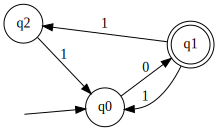

In [105]:
print(nfa.plot().source)
nfa.plot()

# Experimentos estadísticos

In [104]:
nfa = NFA(
    states={'q0', 'q1', 'q2'},
    input_symbols={'0', '1'},
    transitions={
        'q0': {'0': {'q1'}},
        # Use '' as the key name for empty string (lambda/epsilon) transitions
        'q1': {
            #'0': {'q1'},
            '1': {'q0', 'q2'}},
        'q2': {
            '1': {'q0'}
        }
    },
    initial_states={'q0'},
    final_states={'q1'}
)

In [25]:
%%time
data = [(i,nfa.bruteforce_dfs(i)/2**i) for i in range(1, 28)]

CPU times: user 12.5 s, sys: 0 ns, total: 12.5 s
Wall time: 12.5 s


In [113]:
log_data = [(i, math.log(max(1, nfa.bruteforce_dfs(i)))) for i in range(1, 28)]

In [116]:
df = pd.DataFrame(data, columns=["i", "frac"])

<AxesSubplot:xlabel='i'>

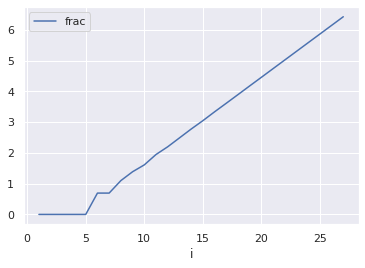

In [117]:
df.plot(x="i", y="frac")

<AxesSubplot:xlabel='i'>

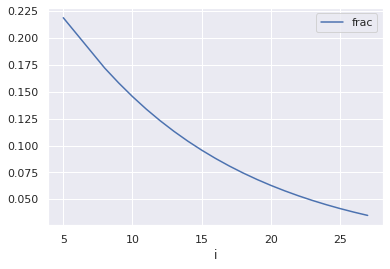

In [28]:
df[df.i >= 5].plot(x="i", y="frac")

In [29]:
def fit_function(x, a, b, c):
    return a*b**(c*x)

In [48]:
predictable_data = df[df.i.between(6,23)]

In [49]:
x_data = predictable_data.i.values
y_data = predictable_data.frac.values
popt, pcov = scipy.optimize.curve_fit(fit_function, x_data, y_data, maxfev=1000)

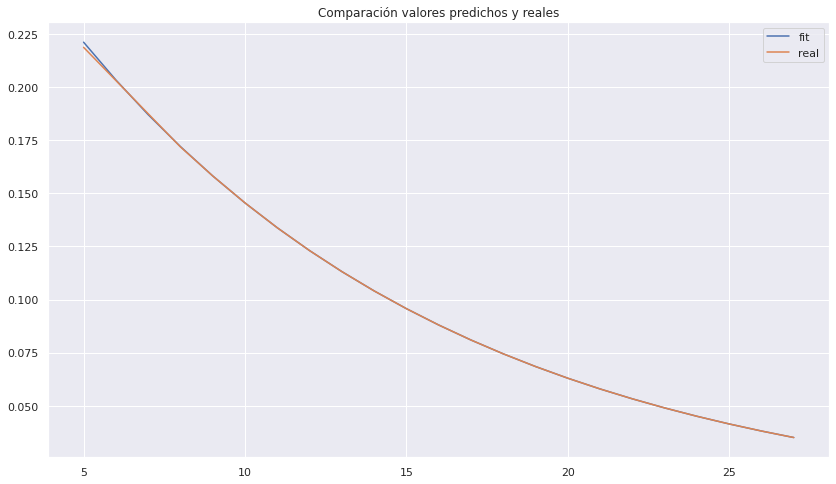

In [50]:
all_data = df[df.i >= 5]
all_x_data = all_data.i.values
all_y_data = all_data.frac.values

fig = plt.plot(all_x_data, fit_function(all_x_data, *popt), label="fit")
plt.plot(all_x_data, all_y_data, label="real")
plt.legend();
plt.title("Comparación valores predichos y reales")
plt.gcf().set_size_inches((14,8))

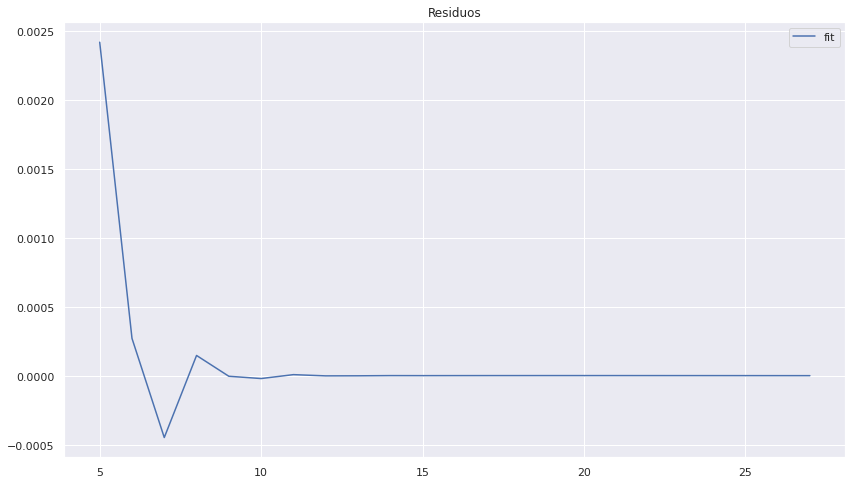

In [51]:
plt.plot(all_x_data, fit_function(all_x_data, *popt) - all_y_data, label="fit")
plt.legend();
plt.title("Residuos")
plt.gcf().set_size_inches((14,8))

In [52]:
k = 29
pred_for_k = fit_function(k, *popt) * 2**k
pred_for_k

15904249.926579835

In [54]:
[(k,int(fit_function(k, *popt) * 2**k)) for k in range(6,28)]

[(6, 13),
 (7, 23),
 (8, 44),
 (9, 80),
 (10, 148),
 (11, 274),
 (12, 504),
 (13, 927),
 (14, 1705),
 (15, 3136),
 (16, 5768),
 (17, 10609),
 (18, 19513),
 (19, 35892),
 (20, 66016),
 (21, 121422),
 (22, 223332),
 (23, 410774),
 (24, 755536),
 (25, 1389654),
 (26, 2555986),
 (27, 4701214)]

In [ ]:
{{6, 13},
 {7, 23},
 {8, 44},
 {9, 81},
 {10, 148},
 {11, 274},
 {12, 504},
 {13, 927},
 {14, 1705}}

In [40]:
%%time
ground_truth_k = nfa.bruteforce_dfs(k)
ground_truth_k

CPU times: user 19.2 s, sys: 0 ns, total: 19.2 s
Wall time: 19.2 s


15902591

In [105]:
popt

array([0.33616588, 0.94819744, 1.57440431])

In [53]:
# Error relativo!
(pred_for_k - ground_truth_k) / ground_truth_k

0.00010431800577873715

In [223]:
# Error relativo!
(pred_for_k - ground_truth_k) / ground_truth_k

0.00143222384490137

- https://arxiv.org/pdf/1802.04708.pdf -> si A es acíclico, el lenguaje es finito. De hecho, $L(A) \subseteq (\Sigma \cup \{\epsilon\})^{|Q|}$
- En general, para $n < |Q|$ el comportamiento se puede hardcodear, por lo que fuerza bruta o `sketch` son necesarios
- http://www.stringology.org/cgi-bin/getfile.cgi?t=pdf&c=-&y=2013&n=03 -> hay un algoritmo $O(|Q|)$ que usa `BFS` y `gcd` para determinar si la densidad del lenguaje es exponencial o polinomial. Se basa en encontrar dos caminos distintos del mismo largo y estado de partida en una componente fuertemente conexa (SCC).
    - Hipótesis 1: si el lenguaje tiene densidad exponencial, el gráfico $|L_n(A)|/2^n$ se verá como una constante tras al menos $n=|Q|$. Estimar es trivial para $n \gg |Q|$, basta retornar esa proporción multiplicada por $2^n$
    - Hipótesis 2: si el lenguaje tiene densidad polinomial, el gráfico $|L_n(A)|/2^n$ se verá como una exponencial
    decayendo. Se puede fittear una función y aproximar para $n \gg |Q|$